<a href="https://colab.research.google.com/github/ktomoya0309/distortion/blob/main/%E3%83%87%E3%82%A3%E3%82%B9%E3%83%88%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%E5%BC%B7%E3%81%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from itertools import product
from decimal import Decimal

In [ ]:
rho = 1.225
Patm = 101325

csvでダウンロードするものを1に変更

In [ ]:
DL_r_theta = 0  #rθのリスト
DL_dPC = 0  #周方向ディストーション強さ
DL_dPR = 0  #半径方向ディストーション強さ

データ読み込み、極座標変換

In [ ]:
df = pd.read_csv('BLI2_Distortion.csv',header = 0)  #0:y,1:z,2:全圧,3:動圧→0y1z2u3StagP
dis_car = df.to_numpy()

y = dis_car[:,0]
z = dis_car[:,1]
Pt = dis_car[:,2]
Pd = dis_car[:,3]

n = int(dis_car.shape[0])
print(n,"\n") #読み込んだデータの行数
r = np.zeros(n)
theta = np.zeros(n)

r = (y**2+z**2)**0.5  #極座標変換
theta = np.arctan2(z,y)*360/(2*math.pi)

dis = np.stack([r,theta,Pt,Pd],1)
print(dis) #読み込み結果を確認

111456 

[[7.79058406e-01 1.04571369e+02 7.00000000e-01 2.15000000e-03]
 [7.78784951e-01 1.04196835e+02 7.00000000e-01 2.15000000e-03]
 [7.78544796e-01 1.03822055e+02 7.00000000e-01 2.16000000e-03]
 ...
 [8.33417662e+00 6.64493523e+01 5.88000000e-01 3.41000000e-04]
 [8.33599424e+00 6.60793837e+01 5.88000000e-01 3.32000000e-04]
 [8.33815927e+00 6.57095919e+01 5.87000000e-01 3.24000000e-04]]


データ整理

In [ ]:
dis_a = dis.copy()
dis_a[:,0] = np.round(dis_a[:,0],1)  #rを四捨五入
dis_a[:,1] = np.round(dis_a[:,1])  #θを四捨五入

df = pd.DataFrame(dis_a,columns = ['r','theta','Pt','Pd'])
df = df.drop_duplicates(subset=['r','theta'])  #rとθの両方が重複している行を削除
df = df.sort_values(by=['theta','r'])  #θ,rを昇順で並べ替え
df = df.reset_index(drop=True)  #インデックス振り直し（無くても良い）

dis_b = df.to_numpy()

rmax = float(max(dis_a[:,0]))
rmin = float(min(dis_a[:,0]))
rlist = np.arange(rmin,rmax+0.1,0.1)  #rのリストを作成
rlist = np.round(rlist,1)

df_r = pd.DataFrame(rlist,columns=['r'])
thetalist = np.arange(-180,181)  #θのリストを作成
df_theta = pd.DataFrame(thetalist,columns=['theta'])

template = pd.DataFrame(list(product(df_r['r'],df_theta['theta'])),columns = ['r','theta']) #r,θのリスト作成
template.round({'r':1,'theta':0})

df['key'] = df['r'].map(str) + ' ' + df['theta'].map(str)  #マージ用keyカラム作成
template['key'] = template['r'].map(str) + ' ' + template['theta'].map(str)

df_after = pd.merge(template,df[['key','Pt','Pd']],how='left',on='key')
df_after = df_after.sort_values(by=['theta','r'])  #θ,rを昇順で並べ替え

df_pivot = df.pivot(index='theta',columns='r',values='Pt').interpolate(axis=1) #全圧のみ取り出し、Nanになっているところは行方向に線形補間
df_pd = df.pivot(index='theta',columns='r',values='Pd').interpolate(axis=1) #動圧のみ取り出し、Nanになっているところは行方向に線形補間

if DL_r_theta == 1:
  df_pivot.T.to_csv("rθ.csv",index = True,header = True)
  files.download('rθ.csv')

周方向ディストーション

In [ ]:
dis_piv = df_pivot.to_numpy()
dis_piv = np.delete(dis_piv,360,0)

n = dis_piv.shape[1]

print("n =",n,"\n")

PAV = np.zeros(n)
PAVLOW = np.zeros(n)

for i in range (n):
  dis_tmp = dis_piv[:,i]
  PAV[i] = np.mean(dis_tmp)
  dis_low = dis_tmp[dis_tmp < PAV[i]]
  PAVLOW[i] = np.mean(dis_low)
  dis_low = np.empty

dPC = (PAV-PAVLOW)/PAV

dPCmax = np.max(dPC)
print("(dPC/P)_max =",dPCmax,"\n")

if DL_dPC == 1:
  df = pd.DataFrame(dPC)
  df.to_csv("dPC.csv",index = False,header = False)
  files.download('dPC.csv')

n = 74 

(dPC/P)_max = 0.1014004576659039 



半径方向ディストーション

In [ ]:
PAV = np.zeros(360)
dPR = np.zeros(360)

dis_all = df_pivot.to_numpy()
PFAV = np.mean(dis_all)

for i in range(360):
  j = i-180
  dis_piv = df_pivot.T[j].to_numpy()

  PAV[i] = np.mean(dis_piv)
  dPR[i] = (PFAV-PAV[i])/PFAV

dPRmax = np.max(dPR)
print("(dPR/P)_max =",dPRmax,"\n")

if DL_dPR == 1:
  df = pd.DataFrame(dPR)
  df.to_csv("dPR.csv",index = False,header = False)
  files.download('dPR.csv')

(dPR/P)_max = 0.03202812826715202 



DC(60)

In [ ]:
P60 = np.zeros(360)

p_dnmc = df_pd.to_numpy()
P_dnmc = np.mean(p_dnmc)

dis_60 = df_pivot.to_numpy()
dis_60_ave = np.mean(dis_60,axis=1)  #角度ごとの全圧平均

for i in range (360):
  P60[i] = np.mean(dis_60_ave[i:i+61])
P60min = min(P60)
min60 = np.argmin(P60)

DC60 = (PFAV-P60min)/P_dnmc
print(DC60)

0.20828401027465535


極座標変換が正しく行われているか確認

Text(0.5, 1.05, 'Polar coordinates')

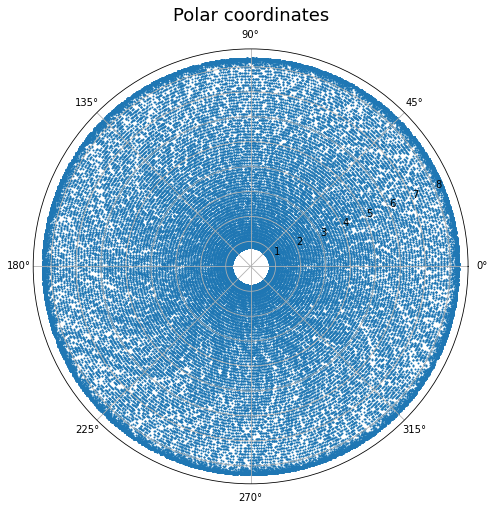

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta,r,s=1)
ax.set_title('Polar coordinates',fontsize=18)

24700


Text(0.5, 1.05, 'before interpolation')

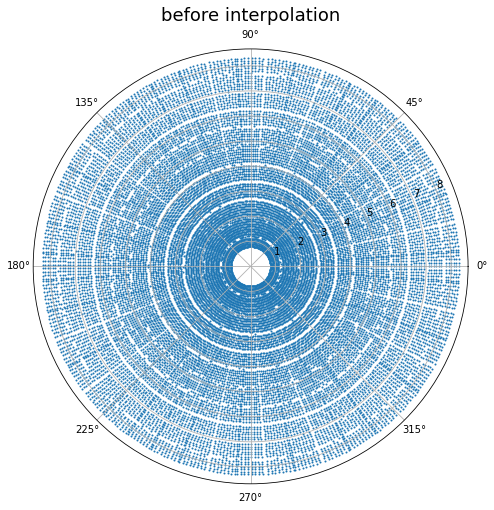

In [ ]:
N = int(dis_b.shape[0])
print(N)
r = np.zeros(N)
theta = np.zeros(N)
r = dis_b[:,0]
theta =dis_b[:,1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta, r,s=1)
ax.set_title('before interpolation',fontsize=18)

27436


Text(0.5, 1.05, 'afterinterpolation')

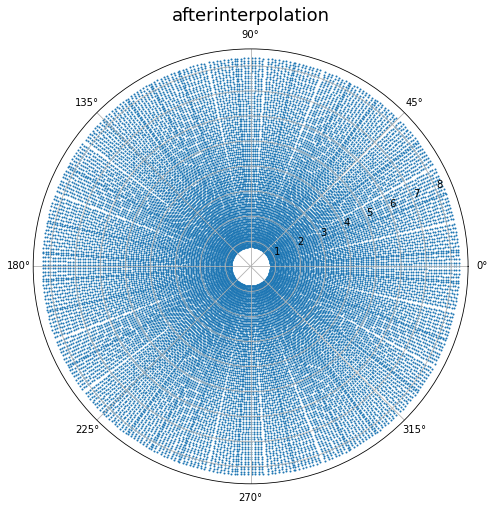

In [ ]:
dis_c = df_after.to_numpy()
N = int(dis_c.shape[0])
print(N)
r = np.zeros(N)
theta = np.zeros(N)
r = dis_c[:,0]
theta =dis_c[:,1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta, r,s=1)
ax.set_title('afterinterpolation',fontsize=18)

リング指定した周方向ディストーション

In [ ]:
i = 8.2  #rを指定

dis_piv = df_pivot[i].to_numpy()
dis_piv = np.delete(dis_piv,360)

PAV = np.mean(dis_piv)
print("PAV =",PAV)

dis_low = dis_piv[dis_piv < PAV]
PAVLOW = np.mean(dis_low)
print("PAVLOW =",PAVLOW)

dPC_i = (PAV-PAVLOW)/PAV
print("dPC/P =",dPC_i)

PAV = 0.6619388888888889
PAVLOW = 0.5969270072992701
dPC/P = 0.09821432564378538


リング指定した半径方向ディストーション

In [ ]:
i = -180  #θを指定(-180～179)

dis_piv = df_pivot.T[i].to_numpy()
dis_all = df_pivot.to_numpy()

PAV = np.mean(dis_piv)
print("PAV =",PAV)

PFAV = np.mean(dis_all)
print("PFAV =",PFAV)

dPR_i = (PFAV-PAV)/PFAV
print("dPR/P =",dPR_i)

PAV = 0.7110675675675676
PFAV = 0.7029744141648575
dPR/P = -0.011512728258147028
